In [1]:
from dask.distributed import Client, LocalCluster
# from dask_jobqueue import SLURMCluster

# # cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='118GB', interface='ib0'
#                       ) 
# cluster.scale(120)
# # # cluster.adapt(minimum=1, maximum=48)

# client = Client(cluster)
client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:37774 Dashboard: http://127.0.0.1:43286/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [2]:
!squeue -u tuchida

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          10550126      visu      viz  tuchida  R       3:13      1 n4366
8


In [3]:
import xarray as xr
import numpy as np
import xscale
import gsw
import os.path as op
from xhistogram.xarray import histogram as xhist

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
xtra = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-S'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'

In [5]:
g = 9.81
Ce = 0.01
rho0 = 999.8
ys,ye = (2000-1,2500+1)
xs,xe = (2300-1,3100+1)
ncoars = 5
zchunk = 15

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc'), 
                         chunks={'z':zchunk}).isel(t=0)
dsmask

<xarray.Dataset>
Dimensions:       (x: 8354, y: 4729, z: 300)
Dimensions without coordinates: x, y, z
Data variables:
    nav_lon       (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(15,), meta=np.ndarray>
    time_counter  float64 dask.array<chunksize=(), meta=np.ndarray>
    tmask         (z, y, x) int8 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    umask         (z, y, x) int8 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    vmask         (z, y, x) int8 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    fmask         (z, y, x) int8 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    tmaskutil     (y, x) int8 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    umaskutil     (y, x) int8 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    vmaskutil     (y, x) int8 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    fmaskutil     (y, x) int8 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    glamt         (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    glamu         (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    glamv         (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    glamf         (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    gphit         (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    gphiu         (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    gphiv         (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    gphif         (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    e1t           (y, x) float64 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    e1u           (y, x) float64 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    e1v           (y, x) float64 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    e1f           (y, x) float64 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    e2t           (y, x) float64 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    e2u           (y, x) float64 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    e2v           (y, x) float64 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    e2f           (y, x) float64 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    ff            (y, x) float64 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    mbathy        (y, x) int16 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    misf          (y, x) int16 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    isfdraft      (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    e3t_0         (z, y, x) float64 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    e3u_0         (z, y, x) float64 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    e3v_0         (z, y, x) float64 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    e3w_0         (z, y, x) float64 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    gdept_0       (z, y, x) float32 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    gdepu         (z, y, x) float32 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    gdepv         (z, y, x) float32 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    gdepw_0       (z, y, x) float32 dask.array<chunksize=(15, 4729, 8354), meta=np.ndarray>
    gdept_1d      (z) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    gdepw_1d      (z) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    e3t_1d        (z) float64 dask.array<chunksize=(15,), meta=np.ndarray>
    e3w_1d        (z) float64 dask.array<chunksize=(15,), meta=np.ndarray>
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200

In [6]:
At = (dsmask.e1t * dsmask.e2t).sel(y=slice(ys,ye),x=slice(xs,xe))
Au = (dsmask.e1u * dsmask.e2u).sel(y=slice(ys,ye),x=slice(xs,xe))
Av = (dsmask.e1v * dsmask.e2v).sel(y=slice(ys,ye),x=slice(xs,xe))
e1u = dsmask.e1u.sel(y=slice(ys,ye),x=slice(xs,xe))
# e2u = dsmask.e2u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e1v = dsmask.e1v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e2v = dsmask.e2v.sel(y=slice(ys,ye),x=slice(xs,xe))
e2t = dsmask.e2t.sel(y=slice(ys,ye),x=slice(xs,xe))
e1t = dsmask.e1t.sel(y=slice(ys,ye),x=slice(xs,xe))
gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                       ).gdepw.sel(y=slice(ys,ye),x=slice(xs,xe))
# e3t = dsmask.e3t_1d[0]
# e3w = dsmask.e3w_1d[0]

In [7]:
cori = gsw.f(dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe)))
fb = xr.apply_ufunc(gsw.f,(dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe))*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
                           / At.coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(),
                    dask='parallelized', output_dtypes=[float,]
                   )
e1tb = e1t.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum()
e2tb = e2t.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum()
e1ub = e1u.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum()
e2vb = e2v.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum()
Aub = Au.coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum()
Avb = Av.coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum()
# Atb = At.coarsen({'y':5,'x':5}, boundary='trim').sum()

In [8]:
def filt(da, area=None):
    
    if area is not None:
        win_2D = (da * area).window
    else:
        win_2D = da.window
    
    win_2D.set(window='hanning', cutoff=20, dim=['y','x'], n=[30,30])
    bw = win_2D.boundary_weights(drop_dims=[])
    da_LS = win_2D.convolve(weights=bw)
    
    if area is not None:
        area_win = area.window
        area_win.set(window='hanning', cutoff=20, dim=['y','x'], n=[30,30])
        bw = area_win.boundary_weights(drop_dims=[])
        da_LS *= area_win.convolve(weights=bw)**-1
    
    return da_LS

In [8]:
xr.open_dataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridW_20091102-20091102.nc'),
               chunks=({'time_counter':1,'depthw':1})).sel(depthw=slice(None,510)).vovecrtz[0,0].data.nbytes*1e-6

158.024264

In [9]:
dsW = xr.open_mfdataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridW_200911*.nc'),
                        chunks={'time_counter':1,'depthw':1}, combine='by_coords'
                       ).sel(depthw=slice(None,510))
dsT = xr.open_mfdataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridT_200911*.nc'),
                        chunks={'time_counter':1,'deptht':1}, combine='by_coords'
                       ).sel(deptht=slice(None,510))
dsS = xr.open_mfdataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridS_200911*.nc'),
                        chunks={'time_counter':1,'deptht':1}, combine='by_coords'
                       ).sel(deptht=slice(None,510))
dsW

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depthw: 74, time_counter: 120, x: 8354, y: 4729)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
  * depthw                (depthw) float32 0.0 1.0000261 ... 487.90018 500.50638
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2009-11-02T00:30:00 ... 2009-11-06T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthw_bounds         (time_counter, depthw, axis_nbounds) float32 dask.array<chunksize=(24, 1, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    vovecrtz              (time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 1, 4729, 8354), meta=np.ndarray>
Attributes:
    name:         /scratch/tmp/5091688/eNATL60-BLBT02_1h_20091102_20091106_gridW
    description:  ocean W grid variables
    title:        ocean W grid variables
    Conventions:  CF-1.6
    timeStamp:    2019-Mar-09 11:57:06 GMT
    uuid:         b541dd09-f592-4c7f-a4fa-0e01f9b6bcfa
    ibegin:       0
    ni:           8354
    jbegin:       0
    nj:           10
    file_name:    eNATL60-BLBT02_1h_20091102_20091106_gridW_20091102-20091102.nc
    TimeStamp:    10/03/2019 00:59:17 +0100

In [10]:
maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)).isel(z=slice(None,len(dsW.depthw)))
    
CT = dsT.votemper.sel(y=slice(ys,ye),x=slice(xs,xe)
                     ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']).chunk({'deptht':1})!=0.
                            )
SA = dsS.vosaline.sel(y=slice(ys,ye),x=slice(xs,xe)
                     ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']).chunk({'deptht':1})!=0.
                            )
w = dsW.vovecrtz.sel(y=slice(ys,ye),x=slice(xs,xe)
                    ).where(xr.DataArray(maskT.data, dims=['depthw','y','x']).chunk({'deptht':1})!=0.
                           )

buoy = -g*xr.apply_ufunc(gsw.sigma0, SA, CT, 
                         dask='parallelized', output_dtypes=[float,]
                        )*1e-3

ws = filt(w.chunk({'depthw':1}), area=At)
bs = filt(buoy.chunk({'deptht':1}), area=At)

wsbs = (ws.isel(depthw=slice(1,None)) 
        * bs.chunk({'deptht':-1}).interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
                                         method='linear').data
       )
wsbs

<xarray.DataArray (time_counter: 120, depthw: 73, y: 500, x: 800)>
dask.array<mul, shape=(120, 73, 500, 800), dtype=float64, chunksize=(1, 1, 500, 800), chunktype=numpy.ndarray>
Coordinates:
  * depthw         (depthw) float64 1.0 2.157 3.471 4.943 ... 475.4 487.9 500.5
    nav_lat        (y, x) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2009-11-02T00:30:00 ... 2009-11-06T23:30:00
Dimensions without coordinates: y, x

In [ ]:
wsbs[:,15].mean('time_counter').plot(figsize=(12,7), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')

In [ ]:
wsbs_b = ((wsbs*At).coarsen({'y':5,'x':5},boundary='trim').sum() 
          * At.coarsen({'y':5,'x':5},boundary='trim').sum()**-1
         )
s_b = ((SA*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
       / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
      )
t_b = ((CT*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
       / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
      )

z10 = 6
sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
                        dask='parallelized', output_dtypes=[float,]
                       ).persist()
b_b = -g*sig0_b*1e-3

nMLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
                       - sig0_b.isel(deptht=z10)
                      ) - 0.03).argmin(dim='deptht')

In [13]:
import dask.array as dsar
xr.concat([xr.DataArray(np.random.random((2,4)), dims=['time','x']).chunk({'time':1}),
           xr.DataArray(np.random.random((3,4)), dims=['time','x']).chunk({'time':1})], 'time')

<xarray.DataArray (time: 5, x: 4)>
dask.array<concatenate, shape=(5, 4), dtype=float64, chunksize=(1, 4), chunktype=numpy.ndarray>
Dimensions without coordinates: time, x

In [12]:
# dirs = np.arange(669601,756000,43200,dtype=int)
# days = np.concatenate((np.arange(11,31,dtype=int), np.arange(1,6,dtype=int))).reshape((5,5))
days = np.arange(6,31, dtype=int).reshape((5,5))
dirs = np.repeat(np.array([1058401]),days.shape[0]+1)
print(days,dirs)

[[ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]
 [26 27 28 29 30]] [1058401 1058401 1058401 1058401 1058401 1058401]


In [17]:
month = 11
year = 2009
for k in range(0,len(dirs)-1):
    for i in days[k]:
        j = month
        l = j
        m = month+1
#         if k > 0:
#             j = m
        if i < days[0,0]:
            l = m

        dsT = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1,'deptht':zchunk}
                             ).sel(deptht=slice(None,810))
        dsS = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1,'deptht':zchunk}
                             ).sel(deptht=slice(None,810))
        d2D = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT-2D_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                             )

        if i == days[0,0]:
            maskT = dsmask.tmask.sel(y=slice(ys,ye),x=slice(xs,xe)
                                        ).isel(z=slice(None,len(dsT.deptht)))

        CT = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        SA = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        ssh = d2D.sossheig[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                  ).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                                      ) != 0.)
    #     del dsT, dsS, dsW


#######################
        s_b = ((SA*At).coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
               / At.coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
              )
        t_b = ((CT*At).coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
               / At.coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
              )
    #     del SA, CT

        z10 = 6
        sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
                                dask='parallelized', output_dtypes=[float,]
                               )
        b_b = -g*sig0_b*1e-3
        
        e3w = dsmask.e3w_0.sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)
        e3t = dsmask.e3t_0.sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)
        e3w_b = ((e3w*At).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True) 
                 * At.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)**-1
                )
        e3t_b = ((e3t*At).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True) 
                 * At.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)**-1
                )

        nMLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
                               - sig0_b.isel(deptht=z10)
                              ) - 0.03).argmin(dim='deptht')
#         MLD = (xr.ones_like(sig0_b) * sig0_b.deptht
#               )[{'deptht':nMLD_b.compute()}].compute()
        MLD = e3t_b.where(e3t_b.z<=nMLD_b.compute()).sum('z').compute()
        del nMLD_b, sig0_b
#         if i == days[0,0]:
#             MLD_b = MLD
#         else:
#             MLD_b = xr.concat([MLD_b, MLD], 'time_counter')
        

#######################    
#         bb_ML = ((b_b * xr.DataArray(e3t.data[:len(b_b.deptht)],dims=['deptht'])
#                  ).where(b_b.deptht <= MLD).sum('deptht') 
#                  * MLD**-1)

        zt_b = e3t_b[:len(dsT.deptht)].cumsum('z',skipna=True)
#         mu1 = 2*(-b_b.deptht) * MLD**-1 + 1
#         mu1 = mu1.where(mu1.deptht <= MLD)
        mu1 = 2*(-zt_b) * MLD**-1 + 1
        mu1 = mu1.where(zt_b <= MLD)
        mu = xr.DataArray(((1.-mu1**2)*(1.+5/21*mu1**2)).data,
                         dims=['deptht','y','x'],
                         coords={'deptht':dsT.deptht.data}
                         ).chunk({'deptht':zchunk})


        bx = (b_b.isel(x=slice(1,None))
              + b_b.isel(x=slice(None,-1)).data
             ) * .5
        by = (b_b.isel(y=slice(1,None))
              + b_b.isel(y=slice(None,-1)).data
             ) * .5
        dbx = bx.diff(dim='x',skipna=True) * e1ub.isel(x=slice(1,-1))**-1
        dby = by.diff(dim='y',skipna=True) * e2vb.isel(y=slice(1,-1))**-1
        
        dbx = (dbx.fillna(0.) * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).isel(x=slice(1,-1)).data,
                                             dims=['deptht','y','x'])
              ).where(dbx.deptht <= MLD.isel(x=slice(1,-1))
                     ).sum('deptht',skipna=True)
        dby = (dby.fillna(0.) * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).isel(y=slice(1,-1)).data,
                                             dims=['deptht','y','x'])
              ).where(dby.deptht <= MLD.isel(y=slice(1,-1))
                     ).sum('deptht',skipna=True)
        
        
        tx = (t_b.isel(x=slice(1,None))
              + t_b.isel(x=slice(None,-1)).data
             ) * .5
        ty = (t_b.isel(y=slice(1,None))
              + t_b.isel(y=slice(None,-1)).data
             ) * .5
        dtx = tx.diff(dim='x',skipna=True) * e1ub.isel(x=slice(1,-1))**-1
        dty = ty.diff(dim='y',skipna=True) * e2vb.isel(y=slice(1,-1))**-1
        
        dtx = (dtx.fillna(0.) * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).isel(x=slice(1,-1)).data,
                                             dims=['deptht','y','x'])
              ).where(dtx.deptht <= MLD.isel(x=slice(1,-1))
                     ).sum('deptht',skipna=True)
        dty = (dty.fillna(0.) * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).isel(y=slice(1,-1)).data,
                                             dims=['deptht','y','x'])
              ).where(dty.deptht <= MLD.isel(y=slice(1,-1))
                     ).sum('deptht',skipna=True)
        
        
        sx = (s_b.isel(x=slice(1,None))
              + s_b.isel(x=slice(None,-1)).data
             ) * .5
        sy = (s_b.isel(y=slice(1,None))
              + s_b.isel(y=slice(None,-1)).data
             ) * .5
        dsx = sx.diff(dim='x',skipna=True) * e1ub.isel(x=slice(1,-1))**-1
        dsy = sy.diff(dim='y',skipna=True) * e2vb.isel(y=slice(1,-1))**-1
        
        dsx = (dsx.fillna(0.) * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).isel(x=slice(1,-1)).data,
                                             dims=['deptht','y','x'])
              ).where(dsx.deptht <= MLD.isel(x=slice(1,-1))
                     ).sum('deptht',skipna=True)
        dsy = (dsy.fillna(0.) * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).isel(y=slice(1,-1)).data,
                                             dims=['deptht','y','x'])
              ).where(dsy.deptht <= MLD.isel(y=slice(1,-1))
                     ).sum('deptht',skipna=True)
        
        
        gradB2 = dbx.isel(y=slice(1,-1))**2 + dby.isel(x=slice(1,-1))**2
        gradT2 = dtx.isel(y=slice(1,-1))**2 + dty.isel(x=slice(1,-1))**2
        gradS2 = dsx.isel(y=slice(1,-1))**2 + dsy.isel(x=slice(1,-1))**2
    #     del b_b, dbx, dby

        gradbb2H = (Ce * mu.isel(y=slice(1,-1),x=slice(1,-1))
                    * gradB2 
#                     * MLD.isel(y=slice(1,-1),x=slice(1,-1))**2
                    * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
                   )
        gradtb2H = (Ce * mu.isel(y=slice(1,-1),x=slice(1,-1))
                    * gradT2 
#                     * MLD.isel(y=slice(1,-1),x=slice(1,-1))**2
                    * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
                   )
        gradsb2H = (Ce * mu.isel(y=slice(1,-1),x=slice(1,-1))
                    * gradS2 
#                     * MLD.isel(y=slice(1,-1),x=slice(1,-1))**2
                    * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
                   )

#         wsbsb_ML = wsbs_b.where(wsbs_b.depthw <= MLD)
#####################  
        if i == days[0,0]:
            BFK_bar = ((gradbb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                dims=['deptht','y','x'],
                                                coords={'deptht':dsT.deptht.data}
                                               ).isel(y=slice(1,-1),x=slice(1,-1))
                       ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                      ).compute()
            BFKt_bar = ((gradtb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                dims=['deptht','y','x'],
                                                coords={'deptht':dsT.deptht.data}
                                               ).isel(y=slice(1,-1),x=slice(1,-1))
                       ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                      ).compute()
            BFKs_bar = ((gradsb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                dims=['deptht','y','x'],
                                                coords={'deptht':dsT.deptht.data}
                                               ).isel(y=slice(1,-1),x=slice(1,-1))
                       ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                      ).compute()
        else:
            BFK_bar = xr.concat([BFK_bar, ((gradbb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                                    dims=['deptht','y','x'],
                                                                    coords={'deptht':dsT.deptht.data}
                                                                   ).isel(y=slice(1,-1),x=slice(1,-1))
                                           ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                                          ).compute()
                                ],
                                'time_counter')
            BFKt_bar = xr.concat([BFKt_bar, ((gradtb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                                    dims=['deptht','y','x'],
                                                                    coords={'deptht':dsT.deptht.data}
                                                                   ).isel(y=slice(1,-1),x=slice(1,-1))
                                             ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                                            ).compute()
                                ],
                                'time_counter')
            BFKs_bar = xr.concat([BFKs_bar, ((gradsb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                                    dims=['deptht','y','x'],
                                                                    coords={'deptht':dsT.deptht.data}
                                                                   ).isel(y=slice(1,-1),x=slice(1,-1))
                                             ).sum('deptht') * MLD.isel(y=slice(1,-1),x=slice(1,-1))**-1
                                            ).compute()
                                ],
                                'time_counter')

        del MLD, gradB2, gradbb2H, gradT2, gradtb2H, gradS2, gradsb2H
        
#         client.restart()
        print(str(l)+'-'+str(i))
    
#     wsbsb_bar.to_netcdf(op.join(scratch,'wsbs_bar_2009-%2d-%02d_%2d-%02d.nc' % (j,days[k,0],l,days[k,-1])))

dsave = BFK_bar.to_dataset(name='BFK')
dsave['BFKt'] = BFKt_bar
dsave['BFKs'] = BFKs_bar
# dsave['MLD'] = MLD_b
dsave.to_netcdf(op.join(scratch,'GulfStream/BFKML_bar-24h_%4d-%02d-%02d_%02d-%02d.nc' 
                        % (year,j,days[0,0],m,days[-1,-1])))
    
#     if k < len(dirs)-2:
#         del BFK_bar

11-27
11-28
11-29
11-30
12-1
12-2
12-3
12-4
12-5
12-6
12-7
12-8
12-9
12-10
12-11
12-12
12-13
12-14
12-15
12-16


In [13]:
e1tb = e1t.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                     boundary='trim').sum(skipna=True)
e2tb = e2t.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                     boundary='trim').sum(skipna=True)
e1ub = e1u.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                     boundary='trim').sum(skipna=True)
e2vb = e2v.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                     boundary='trim').sum(skipna=True)
lat_b = ((dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe))
          * At).isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
         * At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum()**-1
        )
f_b = xr.apply_ufunc(gsw.f, lat_b,
                     dask='parallelized', output_dtypes=[float,]
                    )


month = 5
year = 2010
for k in range(0,len(dirs)-1):
    for i in days[k]:
        j = month
        l = j
        m = month+0
#         if k > 0:
#             j = m
        if i < days[0,0]:
            l = m
        
        dsW = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridW_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1,'depthw':zchunk}
                             ).sel(depthw=slice(None,810))
        dsT = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1,'deptht':zchunk}
                             ).sel(deptht=slice(None,810))
        dsS = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1,'deptht':zchunk}
                             ).sel(deptht=slice(None,810))
        d2D = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT-2D_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                             )

        if i == days[0,0]:
            maskT = dsmask.tmask.sel(y=slice(ys,ye),x=slice(xs,xe)
                                        ).isel(z=slice(None,len(dsT.deptht)))

        CT = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        SA = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        ssh = d2D.sossheig[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                  ).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                                      ) != 0.)
        
        buoy = -g * (xr.apply_ufunc(gsw.sigma0, SA, CT, 
                                    dask='parallelized', output_dtypes=[float,]
                                   )*1e3-rho0) * rho0**-1
        bm = filt(buoy.chunk({'deptht':1}), area=At)
        tm = filt(CT.chunk({'deptht':1}), area=At)
        sm = filt(SA.chunk({'deptht':1}), area=At)
    #     del dsT, dsS, dsW


#######################
        s_b = ((SA*At).sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                                boundary='trim').sum(skipna=True)
               / At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                             boundary='trim').sum(skipna=True)
              )
        t_b = ((CT*At).sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                                boundary='trim').sum(skipna=True)
               / At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars}, 
                                                             boundary='trim').sum(skipna=True)
              )
    #     del SA, CT

        z10 = 6
        sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
                                dask='parallelized', output_dtypes=[float,]
                               )
        b_b = -g*(sig0_b+1e3-rho0)*rho0**-1
        
        e3w = dsmask.e3w_0.sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)
        e3t = dsmask.e3t_0.sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)
        e3w_b = ((e3w*At).sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                   boundary='trim').sum(skipna=True) 
                 * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                               boundary='trim').sum(skipna=True)**-1
                )
        e3t_b = ((e3t*At).sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                   boundary='trim').sum(skipna=True) 
                 * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                               boundary='trim').sum(skipna=True)**-1
                )

        nMLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
                               - sig0_b.isel(deptht=z10)
                              ) - 0.03).argmin(dim='deptht')
#         MLD = (xr.ones_like(sig0_b) * sig0_b.deptht
#               )[{'deptht':nMLD_b.compute()}].compute()
        MLD_b = e3t_b.where(e3t_b.z<=nMLD_b.compute()).sum('z').compute()
        del nMLD_b, sig0_b
        
#         if i == days[0,0]:
#             MLD_b = MLD
#         else:
#             MLD_b = xr.concat([MLD_b, MLD], 'time_counter')
        

#######################    
#         bb_ML = ((b_b * xr.DataArray(e3t.data[:len(b_b.deptht)],dims=['deptht'])
#                  ).where(b_b.deptht <= MLD).sum('deptht') 
#                  * MLD**-1)

        zt_b = e3t_b[:len(dsT.deptht)].cumsum('z',skipna=True)
#         mu1 = 2*(-b_b.deptht) * MLD**-1 + 1
#         mu1 = mu1.where(mu1.deptht <= MLD)
        mu1 = 2*(-zt_b) * MLD_b**-1 + 1
        mu1 = mu1.where(zt_b <= MLD_b)
        mu = xr.DataArray(((1.-mu1**2)*(1.+5/21*mu1**2)).data,
                         dims=['deptht','y','x'],
                         coords={'deptht':dsT.deptht.data}
                         ).chunk({'deptht':zchunk})


        bmx = (bm.isel(x=slice(1,None))
               + bm.isel(x=slice(None,-1)).data
              ) * .5
        bmy = (bm.isel(y=slice(1,None))
               + bm.isel(y=slice(None,-1)).data
              ) * .5
        dbmx = bmx.diff(dim='x') * e1u.isel(x=slice(1,-1))**-1
        dbmy = bmy.diff(dim='y') * e2v.isel(y=slice(1,-1))**-1

        dbmx_coar = ((dbmx.isel(y=slice(1,-1))
                      *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                                    boundary='trim').sum(skipna=True)
                     * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                   boundary='trim').sum(skipna=True)**-1
                    )
        dbmy_coar = ((dbmy.isel(x=slice(1,-1))
                      *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                                    boundary='trim').sum(skipna=True)
                     * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                   boundary='trim').sum(skipna=True)**-1
                    )
        
        
        tmx = (tm.isel(x=slice(1,None))
               + tm.isel(x=slice(None,-1)).data
              ) * .5
        tmy = (tm.isel(y=slice(1,None))
               + tm.isel(y=slice(None,-1)).data
              ) * .5
        dtmx = tmx.diff(dim='x') * e1u.isel(x=slice(1,-1))**-1
        dtmy = tmy.diff(dim='y') * e2v.isel(y=slice(1,-1))**-1

        dtmx_coar = ((dtmx.isel(y=slice(1,-1))
                      *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                                    boundary='trim').sum(skipna=True)
                     * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                   boundary='trim').sum(skipna=True)**-1
                    )
        dtmy_coar = ((dtmy.isel(x=slice(1,-1))
                      *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                                    boundary='trim').sum(skipna=True)
                     * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                   boundary='trim').sum(skipna=True)**-1
                    )
        
        
        smx = (sm.isel(x=slice(1,None))
               + sm.isel(x=slice(None,-1)).data
              ) * .5
        smy = (sm.isel(y=slice(1,None))
               + sm.isel(y=slice(None,-1)).data
              ) * .5
        dsmx = smx.diff(dim='x') * e1u.isel(x=slice(1,-1))**-1
        dsmy = smy.diff(dim='y') * e2v.isel(y=slice(1,-1))**-1

        dsmx_coar = ((dsmx.isel(y=slice(1,-1))
                      *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                                    boundary='trim').sum(skipna=True)
                     * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                   boundary='trim').sum(skipna=True)**-1
                    )
        dsmy_coar = ((dsmy.isel(x=slice(1,-1))
                      *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                                    boundary='trim').sum(skipna=True)
                     * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                   boundary='trim').sum(skipna=True)**-1
                    )
        
        dbmxH = (dbmx_coar 
                 * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).data,
                                dims=['deptht','y','x'])
                ).where(dbmx_coar.deptht <= MLD_b).sum('deptht',skipna=True)
        dbmyH = (dbmy_coar 
                 * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).data,
                                dims=['deptht','y','x'])
                ).where(dbmy_coar.deptht <= MLD_b).sum('deptht',skipna=True)
        dtmxH = (dtmx_coar 
                 * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).data,
                                dims=['deptht','y','x'])
                ).where(dtmx_coar.deptht <= MLD_b).sum('deptht',skipna=True)
        dtmyH = (dtmy_coar 
                 * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).data,
                                dims=['deptht','y','x'])
                ).where(dtmy_coar.deptht <= MLD_b).sum('deptht',skipna=True)
        dsmxH = (dsmx_coar 
                 * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).data,
                                dims=['deptht','y','x'])
                ).where(dsmx_coar.deptht <= MLD_b).sum('deptht',skipna=True)
        dsmyH = (dsmy_coar 
                 * xr.DataArray(e3t_b.isel(z=slice(len(dsT.deptht))).data,
                                dims=['deptht','y','x'])
                ).where(dsmy_coar.deptht <= MLD_b).sum('deptht',skipna=True)

        
        gradB2 = dbmxH**2 + dbmyH**2
        gradT2 = dtmxH**2 + dtmyH**2
        gradS2 = dsmxH**2 + dsmyH**2
    #     del b_b, dbx, dby

        gradbb2H = (Ce * mu
                    * gradB2 
#                     * MLD.isel(y=slice(1,-1),x=slice(1,-1))**2
                    * np.abs(f_b)**-1
                   )
        gradtb2H = (Ce * mu
                    * gradT2 
#                     * MLD.isel(y=slice(1,-1),x=slice(1,-1))**2
                    * np.abs(f_b)**-1
                   )
        gradsb2H = (Ce * mu
                    * gradS2 
#                     * MLD.isel(y=slice(1,-1),x=slice(1,-1))**2
                    * np.abs(f_b)**-1
                   )

#         wsbsb_ML = wsbs_b.where(wsbs_b.depthw <= MLD)
#####################  
        if i == days[0,0]:
            BFK_bar = ((gradbb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                dims=['deptht','y','x'],
                                                coords={'deptht':dsT.deptht.data}
                                               )
                       ).sum('deptht') * MLD_b**-1
                      ).compute()
            BFKt_bar = ((gradtb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                dims=['deptht','y','x'],
                                                coords={'deptht':dsT.deptht.data}
                                               )
                       ).sum('deptht') * MLD_b**-1
                      ).compute()
            BFKs_bar = ((gradsb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                dims=['deptht','y','x'],
                                                coords={'deptht':dsT.deptht.data}
                                               )
                       ).sum('deptht') * MLD_b**-1
                      ).compute()
        else:
            BFK_bar = xr.concat([BFK_bar, ((gradbb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                                    dims=['deptht','y','x'],
                                                                    coords={'deptht':dsT.deptht.data}
                                                                   )
                                           ).sum('deptht') * MLD_b**-1
                                          ).compute()
                                ],
                                'time_counter')
            BFKt_bar = xr.concat([BFKt_bar, ((gradtb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                                    dims=['deptht','y','x'],
                                                                    coords={'deptht':dsT.deptht.data}
                                                                   )
                                             ).sum('deptht') * MLD_b**-1
                                            ).compute()
                                ],
                                'time_counter')
            BFKs_bar = xr.concat([BFKs_bar, ((gradsb2H * xr.DataArray(e3t_b[:len(dsT.deptht)], 
                                                                    dims=['deptht','y','x'],
                                                                    coords={'deptht':dsT.deptht.data}
                                                                   )
                                             ).sum('deptht') * MLD_b**-1
                                            ).compute()
                                ],
                                'time_counter')

        del MLD_b, gradB2, gradbb2H, gradT2, gradtb2H, gradS2, gradsb2H
        
#         client.restart()
        print(str(l)+'-'+str(i))
    
#     wsbsb_bar.to_netcdf(op.join(scratch,'wsbs_bar_2009-%2d-%02d_%2d-%02d.nc' % (j,days[k,0],l,days[k,-1])))

dsave = BFK_bar.to_dataset(name='BFK')
dsave['BFKt'] = BFKt_bar
dsave['BFKs'] = BFKs_bar
# dsave['MLD'] = MLD_b
dsave.to_netcdf(op.join(scratch,'GulfStream/BFKmesoML_bar_Ncoars%02d-24h_%4d-%02d-%02d_%02d-%02d.nc' 
                        % (ncoars,year,j,days[0,0],m,days[-1,-1])), mode='w')
    
#     if k < len(dirs)-2:
#         del BFK_bar

5-6
5-7


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-8efab1835910f79726df2b30e7c4b12c', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-8efab1835910f79726df2b30e7c4b12c', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-8efab1835910f79726df2b30e7c4b12c', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-8efab1835910f79726df2b30e7c4b12c', 0, 0, 0)
NoneType: None


5-8
5-9


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-8c5ab1afa5da8fc1d5c8c64124dccfe0', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-8c5ab1afa5da8fc1d5c8c64124dccfe0', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-6decf9a08dd76337baf96d3fc08f76c7', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-6decf9a08dd76337baf96d3fc08f76c7', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-6decf9a08dd76337baf96d3fc08f76c7', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-6decf9a08dd76337baf96d3fc08f76c7', 0, 0, 0)
NoneType: None


5-10


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-74ed50917700b661c28133c4ae3601fb', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-74ed50917700b661c28133c4ae3601fb', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-74ed50917700b661c28133c4ae3601fb', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-74ed50917700b661c28133c4ae3601fb', 0, 0, 0)
NoneType: None


5-11
5-12


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-f4bd335f6b4d425293ba83fa369e3dcb', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-f4bd335f6b4d425293ba83fa369e3dcb', 0, 0, 0)
NoneType: None


5-13


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-931e9be2adc707d923c9f590aaf389b6', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-931e9be2adc707d923c9f590aaf389b6', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-931e9be2adc707d923c9f590aaf389b6', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-931e9be2adc707d923c9f590aaf389b6', 0, 0, 0)
NoneType: None
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


5-14


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


5-15
5-16


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


5-17


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-7423edad01edd29b67a54ccd1cae7dde', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-7423edad01edd29b67a54ccd1cae7dde', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-7423edad01edd29b67a54ccd1cae7dde', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-7423edad01edd29b67a54ccd1cae7dde', 0, 0, 0)
NoneType: None
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


5-18


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


5-19


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


5-20


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


5-21


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-1e06c07f4271d27b68bccf05344a0fea', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-1e06c07f4271d27b68bccf05344a0fea', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-1e06c07f4271d27b68bccf05344a0fea', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-1e06c07f4271d27b68bccf05344a0fea', 0, 0, 0)
NoneType: None


5-22


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-f546c5bf4fbe42ef97fa329ac76d8416', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-f546c5bf4fbe42ef97fa329ac76d8416', 0, 0, 0)
NoneType: None


5-23
5-24


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


5-25


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-22382889ec4094f7c61ece5973bcd56c', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-22382889ec4094f7c61ece5973bcd56c', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-22382889ec4094f7c61ece5973bcd56c', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-22382889ec4094f7c61ece5973bcd56c', 0, 0, 0)
NoneType: None
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


5-26


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-91406aa08e99fdfcc053f4bc004e31b2', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-91406aa08e99fdfcc053f4bc004e31b2', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-91406aa08e99fdfcc053f4bc004e31b2', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-91406aa08e99fdfcc053f4bc004e31b2', 0, 0, 0)
NoneType: None
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-0356645b0455c385a50fad1afbfd5652', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-0356645b0455c385a50fad1afbfd5652', 0, 0, 0)
NoneType: None

5-27


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-c58fafabb211ea5d3dd56f5829597266', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-c58fafabb211ea5d3dd56f5829597266', 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-c58fafabb211ea5d3dd56f5829597266', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-c58fafabb211ea5d3dd56f5829597266', 0, 0, 0)
NoneType: None
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


5-28
5-29


distributed.scheduler - ERROR - Couldn't gather keys {"('truediv-8e8e6c699f03977d49b0d0a5c3c5b9e4', 0, 0, 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('truediv-8e8e6c699f03977d49b0d0a5c3c5b9e4', 0, 0, 0)
NoneType: None


5-30


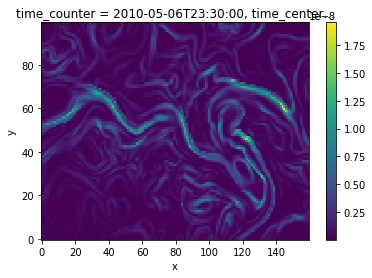

In [14]:
BFK_bar[0].plot()

In [20]:
month = 1
year = 2010
for k in range(0,len(dirs)-1):
    for i in days[k]:
        j = month
        l = j
        m = month
#         if k > 0:
#             j = m
        if i < days[0,0]:
            l = m
#         dsW = xr.open_dataset(op.join(ddir,'%08d-%08d/eNATL60-BLBT02_1h_2009%2d%02d_2009%2d%02d_gridW_2009%2d%02d-2009%2d%02d.nc' 
#                                       % (dirs[k],dirs[k+1]-1,j,days[k,0],11,days[k,-1],l,i,l,i)),
#                               chunks={'time_counter':1,'depthw':zchunk}
#                              ).sel(depthw=slice(None,510))
        dsT = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1,'deptht':zchunk}
                             ).sel(deptht=slice(None,810))
        dsS = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'time_counter':1,'deptht':zchunk}
                             ).sel(deptht=slice(None,810))
        d2D = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT-2D_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                             )

        if i == days[0,0]:
            maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)
                                        ).isel(z=slice(None,len(dsW.depthw)))

        CT = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        SA = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        ssh = d2D.sossheig[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                  ).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                                      ) != 0.)
    #     del dsT, dsS, dsW


#######################
        s_b = ((SA*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
               / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
              )
        t_b = ((CT*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
               / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
              )
    #     del SA, CT

        z10 = 6
        sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
                                dask='parallelized', output_dtypes=[float,]
                               )
        b_b = -g*sig0_b*1e-3

#         nMLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
#                                - sig0_b.isel(deptht=z10)
#                               ) - 0.01).argmin(dim='deptht')
#         MLD = (xr.ones_like(sig0_b) * sig0_b.deptht
#               )[{'deptht':nMLD_b.compute()}].compute()
#         del nMLD_b, sig0_b
#         if i == days[0,0]:
#             MLD_b = MLD
#         else:
#             MLD_b = xr.concat([MLD_b, MLD], 'time_counter')
        MLD = xr.open_dataset(op.join(scratch,
                                      'GulfStream/wsbsb-bar_ML-24h_2010-01-01_01-25.nc')
                             ).MLD

        e3w = dsmask.e3w_0[0].sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)
        e3t = dsmask.e3t_0[0].sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)
        e3w_b = ((e3w*At).coarsen({'y':5,'x':5},boundary='trim').sum() 
                 * At.coarsen({'y':5,'x':5},boundary='trim').sum()**-1
                )
        e3t_b = ((e3t*At).coarsen({'y':5,'x':5},boundary='trim').sum() 
                 * At.coarsen({'y':5,'x':5},boundary='trim').sum()**-1
                )

#######################    
#         bb_ML = ((b_b * xr.DataArray(e3t.data[:len(b_b.deptht)],dims=['deptht'])
#                  ).where(b_b.deptht <= MLD).sum('deptht') 
#                  * MLD**-1)

        zt_b = e3t_b.sum('z')
#         mu1 = 2*(-b_b.deptht) * MLD**-1 + 1
#         mu1 = mu1.where(mu1.deptht <= MLD)
        mu1 = 2*(-zt_b) * MLD**-1 + 1
        mu1 = mu1.where(zt_b <= MLD)
        mu = xr.DataArray(((1.-mu1**2)*(1.+5/21*mu1**2)).data,
                         dims=['deptht','y','x']
                         ).chunk({'deptht':zchunk})

        dbx = (b_b*e2tb).diff(dim='x', label='upper') * Aub[:,:-1]**-1
        dby = (b_b*e1tb).diff(dim='y', label='upper') * Avb[:-1]**-1

        dbx = (dbx.isel(x=slice(1,None))
               + dbx.isel(x=slice(None,-1)).data
              ) * .5
        dby = (dby.isel(y=slice(1,None)) 
               + dby.isel(y=slice(None,-1)).data
              ) * .5
        
        dbx = (dbx * xr.DataArray(e3t_b.data[:len(b_b.deptht)],dims=['deptht','y','x'])
              ).where(dbx.deptht <= MLD.isel(x=slice(1,-1))).sum('deptht')
        dby = (dby * xr.DataArray(e3t_b.data[:len(b_b.deptht)],dims=['deptht','y','x'])
              ).where(dby.deptht <= MLD.isel(y=slice(1,-1))).sum('deptht')
        
        gradB2 = dbx.isel(y=slice(1,-1))**2 + dby.isel(x=slice(1,-1))**2
    #     del b_b, dbx, dby

        gradbb2H = (Ce * mu.isel(y=slice(1,-1),x=slice(1,-1))
                    * gradB2
                    * np.abs(fb).isel(y=slice(1,-1),x=slice(1,-1))**-1
                   )

#         wsbsb_ML = wsbs_b.where(wsbs_b.depthw <= MLD)
#####################  
        if i == days[0,0]:
#             wsbsb_bar = ((wsbsb_ML
#                           * xr.DataArray(e3w[:len(wsbsb_ML.depthw)], dims='depthw',
#                                          coords={'depthw':wsbsb_ML.depthw.data}
#                                         )
#                          ).sum('depthw') * MLD**-1
#                         ).compute()
#     #                     ).sum(dim=['y','x']).persist() * Atb.sum(dim=['y','x'])**-1
            BFK_bar = gradbb2H
        else:
#             wsbsb_bar = xr.concat([wsbsb_bar, ((wsbsb_ML
#                                                 * xr.DataArray(e3w[:len(wsbsb_ML.depthw)], dims='depthw',
#                                                                coords={'depthw':wsbsb_ML.depthw.data}
#                                                               )
#                                                ).sum('depthw') * MLD**-1
#                                               ).compute()
#                                   ],
#                                  'time_counter')
            BFK_bar = xr.concat([BFK_bar, gradbb2H],
                                'time_counter')

        del MLD, gradB2, gradbb2H
        
#         client.restart()
        print(str(l)+'-'+str(i))
    
#     wsbsb_bar.to_netcdf(op.join(scratch,'wsbs_bar_2009-%2d-%02d_%2d-%02d.nc' % (j,days[k,0],l,days[k,-1])))

BFK_bar.to_netcdf(op.join(scratch,'GulfStream/BFK-3D_bar-24h_%4d-%02d-%02d_%02d-%02d.nc' % (year,j,days[0,0],m,days[-1,-1])))
    
#     if k < len(dirs)-2:
#         del BFK_bar

1-1
1-2
1-3
1-4
1-5
1-6


/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


1-7
1-8
1-9
1-10
1-11
1-12
1-13
1-14
1-15
1-16
1-17
1-18
1-19
1-20
1-21
1-22


/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


1-23
1-24
1-25


distributed.nanny - WARNING - Restarting worker


In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
fig.set_tight_layout(True)
wsbsb_bar[0].plot(ax=ax1, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
(BFK_bar[0]*.1).plot(ax=ax2, vmin=0, vmax=1e-7, cmap='Reds')

In [ ]:
MLD_b.mean('time_counter').plot(vmax=1.4e2, vmin=20, cmap='Blues')

In [ ]:
wsbsb_ML.chunk({'depthw':-1}).mean(['time_counter','depthw']).plot(figsize=(8,5), cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

In [ ]:
fig, ax = plt.subplots(figsize=(14,4))
wsbs_bar.plot(ax=ax, c='r', lw=3)
gradbb2H_bar.plot(ax=ax, c='k', ls='--', lw=2)

In [ ]:
gradbb2H.name = 'BFK'
wsbsb_ML.name = 'wsbs'
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(20,5))
# fig.set_tight_layout(True)
gs = GridSpec(1,5,figure=fig)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2:4])
ax3 = fig.add_subplot(gs[0,4])
wsbsb_ML[0,14,1:-1,1:-1].plot(ax=ax1, vmax=5e-8, cmap='coolwarm', rasterized=True)
(1e2*gradbb2H[15,0]).plot(ax=ax2, vmin=0., vmax=5e-8, cmap='Reds', rasterized=True)
xhist(1e2*gradbb2H[1:].transpose('time_counter','deptht','y','x').chunk({'time_counter':1}), 
      wsbsb_ML[:,:,1:-1,1:-1].chunk({'time_counter':1}),
      bins=[np.logspace(-11,-6,30), np.logspace(-11,-6,30)]).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-11,1e-6), np.linspace(1e-11,1e-6), c='grey', ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-11,1e-6])
ax3.set_xlim([1e-11,1e-6])
ax3.set_xlabel(r"$\overline{w'b'}^{xy}$ [m$^2$ s$^{-3}$]", fontsize=14)
ax3.set_ylabel(r"$\frac{H_{\tt ML}^2|\nabla_{\tt H}\overline{b}^{xyz}|^2}{f}$ [m$^2$ s$^{-3}$]", 
               fontsize=14)
ax1.set_title(r"$\overline{w'b'}^{xy}$ [m$^2$ s$^{-3}$]", fontsize=15)
ax2.set_title(r"$H_{\tt ML}^2|\nabla_{\tt H}\overline{b}^{xyz}|^2 / f$ [m$^2$ s$^{-3}$]", 
             fontsize=15)
fig.suptitle(r"Nov. 2, 2009", fontsize=17, y=1.02)
# plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/Nov-2-2009_GulfStreamPatch.pdf')